In [1]:
# @title Setup mmseqs2 + hhsuite + MSA pairformer
import os
import re
import sys
import gc
import io
import json
import time
import pickle
import shutil
import hashlib
import tarfile
import tempfile
import warnings
import importlib
import subprocess
from pathlib import Path
from sys import version_info
from contextlib import redirect_stdout, redirect_stderr
from typing import List, Dict, Optional, Tuple, Union
# from google.colab import files

import requests
import torch
import numpy as np
import matplotlib.pyplot as plt

class ColabFoldPairedMSA:
    """Simple class to get paired MSAs from ColabFold with extended filtering and genomic distance support"""
    def __init__(self, host_url: str = "https://api.colabfold.com",
                 cache_dir: Optional[str] = None):
        self.host_url = host_url
        self.job_id = None
        self.parsed_entries = None  # List of parsed entries with metadata

        # Set up cache directory
        if cache_dir is None:
            self.cache_dir = Path.home() / ".colabfold_cache"
        else:
            self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

        print(f"Cache directory: {self.cache_dir}")

        # Initialize UniProt converter
        self._init_uniprot_converter()

    def _init_uniprot_converter(self):
        """Initialize UniProt ID to number conversion tables"""
        from string import ascii_uppercase

        # Initialize encoding tables
        self.pa = {a: 0 for a in ascii_uppercase}
        for a in ["O", "P", "Q"]:
            self.pa[a] = 1

        self.ma = [[{} for k in range(6)], [{} for k in range(6)]]

        # Fill encoding tables
        for n, t in enumerate(range(10)):
            for i in [0, 1]:
                for j in [0, 4]:
                    self.ma[i][j][str(t)] = n

        for n, t in enumerate(list(ascii_uppercase) + list(range(10))):
            for i in [0, 1]:
                for j in [1, 2]:
                    self.ma[i][j][str(t)] = n
            self.ma[1][3][str(t)] = n

        for n, t in enumerate(ascii_uppercase):
            self.ma[0][3][str(t)] = n
            for i in [0, 1]:
                self.ma[i][5][str(t)] = n

        self.upi_encoding = {}
        hex_chars = list(range(10)) + ['A', 'B', 'C', 'D', 'E', 'F']
        for n, char in enumerate(hex_chars):
            self.upi_encoding[str(char)] = n

    def _extract_uniprot_id(self, header: str) -> str:
        """Extract UniProt ID from header."""
        pos = header.find("UniRef")
        if pos == -1:
            return ""

        start = header.find('_', pos)
        if start == -1:
            return ""
        start += 1

        end = start
        while end < len(header) and header[end] not in ' _\t':
            end += 1

        uid = header[start:end]

        # Validate - including UPI IDs
        if len(uid) >= 3 and uid[:3] == "UPI":
            return uid

        # Regular UniProt ID validation
        if len(uid) not in [6, 10]:
            return ""
        if not uid[0].isalpha():
            return ""

        return uid

    def _uniprot_to_number(self, uniprot_ids: List[str]) -> List[int]:
        """Convert UniProt IDs to numbers for distance calculation."""
        numbers = []
        for uni in uniprot_ids:
            if not uni or not uni[0].isalpha():
                numbers.append(0)
                continue

            # Handle UPI IDs
            if uni.startswith("UPI") and len(uni) == 13:
                hex_part = uni[3:]  # Remove "UPI" prefix
                num = 0
                tot = 1

                # Process hexadecimal characters in reverse order
                for u in reversed(hex_part):
                    if str(u) in self.upi_encoding:
                        num += self.upi_encoding[str(u)] * tot
                        tot *= 16  # Base 16 for hexadecimal
                    else:
                        # Invalid hex character, assign 0
                        num = 0
                        break
                # Add offset to distinguish UPI IDs from standard ones
                # Use a large offset to avoid collisions
                numbers.append(num + 10**15)
                continue

            p = self.pa.get(uni[0], 0)
            tot, num = 1, 0

            if len(uni) == 10:
                for n, u in enumerate(reversed(uni[-4:])):
                    if str(u) in self.ma[p][n]:
                        num += self.ma[p][n][str(u)] * tot
                        tot *= len(self.ma[p][n].keys())

            for n, u in enumerate(reversed(uni[:6])):
                if n < len(self.ma[p]) and str(u) in self.ma[p][n]:
                    num += self.ma[p][n][str(u)] * tot
                    tot *= len(self.ma[p][n].keys())

            numbers.append(num)

        return numbers

    def _calculate_genomic_distances(self, entry: Dict) -> List[int]:
        """Calculate sequential distances between adjacent chains."""
        distances = []
        nums = entry['uniprot_nums']

        for i in range(1, len(nums)):
            if nums[i-1] and nums[i]:  # Both must be valid numbers
                dist = abs(nums[i] - nums[i-1])
                distances.append(dist)
            else:
                distances.append(-1)  # Invalid distance

        return distances

    def _get_cache_key(self, sequences: List[str], genomic_distance: Optional[int],
                       prefix: Optional[str]) -> str:
        """Generate a unique cache key for the request"""
        # Always use genomic_distance=20 for caching to maximize reuse
        cache_genomic_distance = 20 if genomic_distance is not None else None

        # Create a deterministic string representation
        cache_data = {
            'sequences': sequences,
            'genomic_distance': cache_genomic_distance,
            'prefix': prefix,
            'host_url': self.host_url
        }
        cache_str = json.dumps(cache_data, sort_keys=True)

        # Generate hash
        cache_hash = hashlib.sha256(cache_str.encode()).hexdigest()[:16]

        # Create human-readable prefix
        seq_info = f"{len(sequences)}seq"
        if prefix:
            seq_info += f"_{prefix}"

        return f"{seq_info}_{cache_hash}"

    def _load_from_cache(self, cache_key: str) -> bool:
        """Try to load parsed entries from cache"""
        cache_file = self.cache_dir / f"{cache_key}.pkl"

        if cache_file.exists():
            try:
                with open(cache_file, 'rb') as f:
                    cache_data = pickle.load(f)

                self.parsed_entries = cache_data['parsed_entries']
                self.job_id = cache_data.get('job_id', f"cached_{cache_key}")

                print(f"Loaded from cache: {cache_key}")
                return True
            except Exception as e:
                print(f"Cache load failed: {e}")
                return False

        return False

    def _save_to_cache(self, cache_key: str):
        """Save parsed entries to cache"""
        cache_file = self.cache_dir / f"{cache_key}.pkl"

        try:
            cache_data = {
                'parsed_entries': self.parsed_entries,
                'job_id': self.job_id,
                'timestamp': time.time()
            }

            with open(cache_file, 'wb') as f:
                pickle.dump(cache_data, f)

            print(f"Saved to cache: {cache_key}")

            # Also save a human-readable info file
            info_file = self.cache_dir / f"{cache_key}_info.json"
            info_data = {
                'job_id': self.job_id,
                'num_entries': len(self.parsed_entries),
                'num_chains': len(self.parsed_entries[0]['sequences']) if self.parsed_entries else 0,
                'timestamp': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(cache_data['timestamp']))
            }
            with open(info_file, 'w') as f:
                json.dump(info_data, f, indent=2)

        except Exception as e:
            print(f"Cache save failed: {e}")

    def clear_cache(self, older_than_days: Optional[int] = None):
        """Clear cache files, optionally only those older than specified days"""
        import glob

        cache_files = glob.glob(str(self.cache_dir / "*.pkl"))
        removed = 0

        for cache_file in cache_files:
            if older_than_days is not None:
                # Check age
                age_days = (time.time() - os.path.getmtime(cache_file)) / (24 * 3600)
                if age_days < older_than_days:
                    continue

            try:
                os.remove(cache_file)
                # Also remove info file if exists
                info_file = cache_file.replace('.pkl', '_info.json')
                if os.path.exists(info_file):
                    os.remove(info_file)
                removed += 1
            except:
                pass

        print(f"Removed {removed} cache files")

    def submit_or_load_from_cache(self,
                                  sequences: List[str],
                                  genomic_distance: Optional[int] = 20,
                                  prefix: Optional[str] = None,
                                  use_cache: bool = True) -> Tuple[str, bool]:
        """Submit sequences or load from cache if available

        Always uses genomic_distance=20 for caching to maximize reuse.

        Returns:
            Tuple of (job_id, from_cache) where from_cache indicates if data was loaded from cache
        """
        # Always use distance=20 for caching
        cache_genomic_distance = 20 if genomic_distance is not None else None

        # Generate cache key
        cache_key = self._get_cache_key(sequences, cache_genomic_distance, prefix)
        self._current_cache_key = cache_key

        # Try to load from cache
        if use_cache and self._load_from_cache(cache_key):
            return self.job_id, True

        # If not in cache, submit normally with distance=20
        self.submit(sequences, cache_genomic_distance, prefix)
        return self.job_id, False

    def submit(self,
               sequences: List[str],
               genomic_distance: Optional[int] = 20,
               prefix: Optional[str] = None) -> str:
        """Submit sequences and return job ID"""
        # Create query
        query = ""
        for i, seq in enumerate(sequences, start=101):
            if prefix:
                query += f">{prefix}_{i}\n{seq}\n"
            else:
                query += f">{i}\n{seq}\n"

        # Determine mode based on number of sequences
        if len(sequences) == 1:
            # Single sequence - use regular MSA mode
            mode = "env"
            endpoint = "ticket/msa"
        else:
            # Multiple sequences - use pairing mode
            if genomic_distance is None:
                mode = "paircomplete"
            else:
                mode = f"paircomplete-pairfilterprox_{genomic_distance}"
            endpoint = "ticket/pair"

        response = requests.post(
            f'{self.host_url}/{endpoint}',
            data={'q': query, 'mode': mode},
            timeout=30
        )

        if response.status_code != 200:
            raise Exception(f"Failed to submit: {response.text}")

        self.job_id = response.json()['id']
        print(f"Job submitted: {self.job_id} with mode: {mode}")
        return self.job_id

    def wait(self, check_interval: int = 5):
        """Wait for job completion"""
        while True:
            response = requests.get(f'{self.host_url}/ticket/{self.job_id}', timeout=30)
            status = response.json().get('status', 'UNKNOWN')
            print(f"Status: {status}")

            if status == "COMPLETE":
                break
            elif status == "ERROR":
                raise Exception("Job failed")
            time.sleep(check_interval)

    def download_and_parse(self, output_dir: str = "results"):
        """Download results and parse the MSA"""
        # Download
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        tar_path = os.path.join(output_dir, f"{self.job_id}.tar.gz")

        response = requests.get(f'{self.host_url}/result/download/{self.job_id}', timeout=60)
        with open(tar_path, 'wb') as f:
            f.write(response.content)

        # Extract
        with tarfile.open(tar_path) as tar:
            tar.extractall(output_dir)

        # Check if this is a paired MSA or single sequence MSA
        pair_a3m = os.path.join(output_dir, 'pair.a3m')
        if os.path.exists(pair_a3m):
            # Paired MSA
            self.parsed_entries = self._parse_paired_a3m(pair_a3m)
        else:
            # Single sequence - combine multiple MSA files
            self.parsed_entries = self._parse_single_msas(output_dir)

        # Save to cache if we have a cache key
        if hasattr(self, '_current_cache_key'):
            self._save_to_cache(self._current_cache_key)

    def _parse_msa_lines(self, lines: List[str]) -> List[Dict]:
        """Parse MSA lines into structured entries with UniProt ID extraction"""
        entries = []
        i = 0
        is_first = True

        while i < len(lines):
            line = lines[i].rstrip()

            if line.startswith('>'):
                header = line
                seq_lines = []
                i += 1

                # Collect sequence lines
                while i < len(lines) and not lines[i].startswith('>'):
                    if lines[i].strip():
                        seq_lines.append(lines[i].rstrip())
                    i += 1

                sequence = ''.join(seq_lines)

                # Parse header
                header_parts = header.split('\t')
                header_clean = header_parts[0].lstrip('>').replace('UniRef100_', '')

                # Extract UniProt ID
                uid = self._extract_uniprot_id(header)
                has_uniref = "UniRef" in header
                uniprot_num = 0

                if uid:
                    # Convert to number
                    uniprot_nums = self._uniprot_to_number([uid])
                    uniprot_num = uniprot_nums[0] if uniprot_nums else 0

                # For query sequence
                if is_first:
                    coverage = 1.0
                    identity = 1.0
                    evalue = 0.0
                    alnscore = float('inf')
                    is_first = False
                else:
                    # Extract metadata from header
                    coverage = None
                    identity = None
                    evalue = None
                    alnscore = None

                    if len(header_parts) >= 10:
                        try:
                            alnscore = float(header_parts[1])
                            identity = float(header_parts[2])
                            evalue = float(header_parts[3])
                            q_start = int(header_parts[4])
                            q_end = int(header_parts[5])
                            q_len = int(header_parts[6])
                            coverage = (q_end - q_start + 1) / q_len
                        except:
                            pass

                    # Fallback values
                    if coverage is None:
                        coverage = 0.0
                    if identity is None:
                        identity = 0.0
                    if evalue is None:
                        evalue = float('inf')
                    if alnscore is None:
                        alnscore = 0.0

                entries.append({
                    'header': header_clean,
                    'sequence': sequence,
                    'coverage': coverage,
                    'identity': identity,
                    'evalue': evalue,
                    'alnscore': alnscore,
                    'uid': uid,
                    'uniprot_num': uniprot_num,
                    'has_uniref': has_uniref
                })
            else:
                i += 1

        return entries

    def _parse_paired_a3m(self, a3m_path: str) -> List[Dict]:
        """Parse paired A3M file into list of entries with UniProt ID tracking"""
        # First, separate MSAs by chain ID
        raw_msas = {}
        update_M = True
        M = None

        with open(a3m_path, 'r') as f:
            for line in f:
                if "\x00" in line:
                    line = line.replace("\x00", "")
                    update_M = True

                if line.startswith(">") and update_M:
                    # Extract chain ID (101, 102, etc.)
                    M = int(line[1:].rstrip().split('_')[-1])
                    update_M = False
                    if M not in raw_msas:
                        raw_msas[M] = []

                if M is not None:
                    raw_msas[M].append(line.rstrip())

        # Parse each chain's MSA
        parsed_msas = {}
        for seq_id, lines in raw_msas.items():
            parsed_msas[seq_id] = self._parse_msa_lines(lines)

        # Get sorted chain IDs
        seq_ids = sorted(parsed_msas.keys())

        # IMPORTANT: All chains should have the same number of sequences when paired
        num_entries_per_chain = [len(parsed_msas[sid]) for sid in seq_ids]
        if len(set(num_entries_per_chain)) > 1:
            print(f"Warning: Chains have different numbers of sequences: {dict(zip(seq_ids, num_entries_per_chain))}")
            print("Taking minimum to preserve pairing")

        min_entries = min(num_entries_per_chain)

        # Stitch entries together - sequences at the same position are paired
        stitched_entries = []
        for i in range(min_entries):
            # Collect info from each chain at position i
            headers = []
            sequences = []
            coverages = []
            identities = []
            evalues = []
            alnscores = []
            uids = []
            uniprot_nums = []
            has_uniref = True  # Will be False if any chain doesn't have UniRef

            for sid in seq_ids:
                entry = parsed_msas[sid][i]
                headers.append(entry['header'])
                sequences.append(entry['sequence'])
                coverages.append(entry['coverage'])
                identities.append(entry['identity'])
                evalues.append(entry['evalue'])
                alnscores.append(entry['alnscore'])
                uids.append(entry['uid'])
                uniprot_nums.append(entry['uniprot_num'])
                has_uniref = has_uniref and entry['has_uniref']

            stitched_entries.append({
                'headers': headers,
                'sequences': sequences,
                'coverages': coverages,
                'identities': identities,
                'evalues': evalues,
                'alnscores': alnscores,
                'uids': uids,
                'uniprot_nums': uniprot_nums,
                'has_uniref': has_uniref,
                'is_query': (i == 0)
            })

        return stitched_entries

    def _parse_single_msas(self, output_dir: str) -> List[Dict]:
        """Parse and combine single sequence MSAs"""
        # MSA files to look for
        msa_files = ['uniref.a3m', 'bfd.mgnify30.metaeuk30.smag30.a3m']

        all_entries = []
        seen_sequences = set()

        for msa_file in msa_files:
            msa_path = os.path.join(output_dir, msa_file)
            if os.path.exists(msa_path):
                with open(msa_path, 'r') as f:
                    lines = f.readlines()

                entries = self._parse_msa_lines(lines)

                # Add non-duplicate entries
                for entry in entries:
                    if entry['sequence'] not in seen_sequences:
                        seen_sequences.add(entry['sequence'])
                        all_entries.append({
                            'headers': [entry['header']],
                            'sequences': [entry['sequence']],
                            'coverages': [entry['coverage']],
                            'identities': [entry['identity']],
                            'evalues': [entry['evalue']],
                            'alnscores': [entry['alnscore']],
                            'uids': [entry['uid']],
                            'uniprot_nums': [entry['uniprot_num']],
                            'has_uniref': entry['has_uniref'],
                            'is_query': len(all_entries) == 0
                        })

        return all_entries

    def save_msa(self,
                 output_file: str,
                 min_coverage: Optional[float] = None,
                 min_identity: Optional[float] = None,
                 max_evalue: Optional[float] = None,
                 min_alnscore: Optional[float] = None,
                 max_genomic_distance: Optional[int] = None) -> Tuple[int, List[Dict]]:
        """Save MSA with optional filtering including genomic distance

        Returns:
            Tuple of (number of sequences written, list of filtered entries)
        """
        if not self.parsed_entries:
            raise ValueError("No MSA loaded. Run download_and_parse first.")

        # Smart parsing: convert percentages to fractions
        if min_coverage is not None and min_coverage > 1:
            min_coverage = min_coverage / 100
        if min_identity is not None and min_identity > 1:
            min_identity = min_identity / 100

        sequences_written = 0
        sequences_filtered = 0
        filtered_entries = []  # Store entries that pass the filter

        num_chains = len(self.parsed_entries[0]['sequences']) if self.parsed_entries else 0

        with open(output_file, 'w') as f:
            for entry in self.parsed_entries:
                # Skip filtering for query sequence
                if not entry['is_query']:
                    # All chains must pass the filter
                    filter_reasons = []

                    if min_coverage and any(c < min_coverage for c in entry['coverages']):
                        filter_reasons.append(f"coverage < {min_coverage}")
                    if min_identity and any(i < min_identity for i in entry['identities']):
                        filter_reasons.append(f"identity < {min_identity}")
                    if max_evalue is not None and any(e > max_evalue for e in entry['evalues'] if e is not None):
                        filter_reasons.append(f"evalue > {max_evalue}")
                    if min_alnscore is not None and any(a < min_alnscore for a in entry['alnscores'] if a is not None):
                        filter_reasons.append(f"alnscore < {min_alnscore}")

                    # Genomic distance filtering
                    if max_genomic_distance is not None and entry['has_uniref']:
                        distances = self._calculate_genomic_distances(entry)

                        if num_chains == 2:
                            # Simple case: check single distance
                            if distances[0] != -1 and distances[0] > max_genomic_distance:
                                filter_reasons.append(f"genomic distance > {max_genomic_distance}")
                        else:
                            # For >2 chains: check if all distances exceed threshold
                            # (relaxed filtering - keep if ANY distance is within threshold)
                            valid_distances = [d for d in distances if d != -1]
                            if valid_distances and all(d > max_genomic_distance for d in valid_distances):
                                filter_reasons.append(f"all genomic distances > {max_genomic_distance}")

                    if filter_reasons:
                        sequences_filtered += 1
                        continue

                # Write entry with modified header
                if entry['is_query']:
                    # Query header format: query_len1_len2_len3
                    header = "query"
                    for seq in entry['sequences']:
                        header += f"_len{len(seq)}"
                else:
                    # Regular header format: UID1_UID2_UID3_dist1-2_dist2-3
                    # First write UIDs (or original headers if no UID)
                    header_parts = []
                    for i, uid in enumerate(entry['uids']):
                        if uid:
                            header_parts.append(uid)
                        else:
                            header_parts.append(entry['headers'][i])

                    header = '_'.join(header_parts)

                    # Add distances if we have valid UIDs
                    if entry['has_uniref'] and all(entry['uids']):
                        distances = self._calculate_genomic_distances(entry)
                        for dist in distances:
                            if dist != -1:
                                header += f"_{dist}"

                sequence = ''.join(entry['sequences']).replace('\x00','')
                f.write(f">{header}\n{sequence}\n")
                sequences_written += 1
                filtered_entries.append(entry)

        print(f"Saved {sequences_written} sequences to {output_file}")
        if sequences_filtered > 0:
            print(f"Filtered out {sequences_filtered} sequences")
        return sequences_written, filtered_entries

    def get_stats(self, entries: Optional[List[Dict]] = None) -> Dict:
        """Get statistics about the MSA

        Args:
            entries: Optional list of entries to calculate stats from.
                    If None, uses all parsed entries.
        """
        if entries is None:
            entries = self.parsed_entries

        if not entries:
            return {}

        num_chains = len(entries[0]['sequences']) if entries else 0

        stats = {
            'num_chains': num_chains,
            'num_entries': len(entries),
        }

        # Per-chain statistics
        for i in range(num_chains):
            coverages = [e['coverages'][i] for e in entries[1:]]  # Skip query
            identities = [e['identities'][i] for e in entries[1:]]
            evalues = [e['evalues'][i] for e in entries[1:] if e['evalues'][i] is not None]
            alnscores = [e['alnscores'][i] for e in entries[1:] if e['alnscores'][i] is not None]

            chain_id = i + 101
            stats[f'chain_{chain_id}'] = {
                'query_length': len(entries[0]['sequences'][i]) if entries else 0,
                'avg_coverage': sum(coverages) / len(coverages) if coverages else 0,
                'avg_identity': sum(identities) / len(identities) if identities else 0,
                'avg_evalue': sum(evalues) / len(evalues) if evalues else 0,
                'avg_alnscore': sum(alnscores) / len(alnscores) if alnscores else 0,
                'min_evalue': min(evalues) if evalues else None,
                'max_alnscore': max(alnscores) if alnscores else None,
            }

        return stats

def get_paired_msa(sequences: Union[str, List[str]],
                   output_file: str,
                   genomic_distance: Optional[int] = 20,
                   min_coverage: Optional[float] = None,
                   min_identity: Optional[float] = None,
                   max_evalue: Optional[float] = None,
                   min_alnscore: Optional[float] = None,
                   prefix: Optional[str] = None,
                   host_url: str = "https://api.colabfold.com",
                   cache_dir: Optional[str] = None,
                   use_cache: bool = True,
                   keep_temp: bool = False) -> str:
    """
    Simple wrapper to get paired MSA from ColabFold with extended filtering

    Args:
        sequences: List of protein sequences or a single string with ':' delimiter
        output_file: Path to save the stitched MSA
        genomic_distance: Genomic distance for pairing (default: 20, None for no filtering)
        min_coverage: Minimum coverage filter (0-1 or 0-100 for percentage)
        min_identity: Minimum identity filter (0-1 or 0-100 for percentage)
        max_evalue: Maximum e-value filter (e.g., 1e-5, 0.001)
        min_alnscore: Minimum alignment score filter
        prefix: Optional prefix for sequence IDs
        host_url: ColabFold API URL
        cache_dir: Directory for caching results (default: ~/.colabfold_cache)
        use_cache: Whether to use caching (default: True)
        keep_temp: If True, keep temporary files for debugging (default: False)

    Returns:
        Path to the output file
    """
    # Handle string input
    if isinstance(sequences, str):
        # Split by ':' and clean up
        sequences = [seq.strip() for seq in sequences.split(':') if seq.strip()]

    # Further cleanup of sequences
    cleaned_sequences = []
    for seq in sequences:
        # Remove whitespace and convert to uppercase
        seq = ''.join(seq.split()).upper()
        # Only add non-empty sequences
        if seq:
            cleaned_sequences.append(seq)

    if not cleaned_sequences:
        raise ValueError("No valid sequences provided")

    sequences = cleaned_sequences

    # Store user's requested genomic distance
    user_genomic_distance = genomic_distance

    # Always fetch with distance=20 for better caching
    fetch_genomic_distance = 20 if genomic_distance is not None else None

    # Create temp directory
    if keep_temp:
        # Create a permanent temp directory
        temp_dir = tempfile.mkdtemp(prefix="colabfold_")
        print(f"Temporary files will be kept in: {temp_dir}")
    else:
        # Use context manager for automatic cleanup
        temp_context = tempfile.TemporaryDirectory()
        temp_dir = temp_context.__enter__()

    try:
        # Create handler with cache support
        msa = ColabFoldPairedMSA(host_url, cache_dir)

        # Store cache key for later use - always use distance=20 for caching
        cache_key = msa._get_cache_key(sequences, fetch_genomic_distance, prefix)
        msa._current_cache_key = cache_key

        # Submit or load from cache
        job_id, from_cache = msa.submit_or_load_from_cache(sequences, fetch_genomic_distance, prefix, use_cache)

        # Only wait and download if it's a new job (not from cache)
        if not from_cache:
            msa.wait()
            # Download and parse
            msa.download_and_parse(temp_dir)

        # Save MSA to temporary file first with user's requested distance filtering
        temp_output = os.path.join(temp_dir, "temp_output.a3m")
        num_sequences, filtered_entries = msa.save_msa(
            temp_output,
            min_coverage,
            min_identity,
            max_evalue,
            min_alnscore,
            max_genomic_distance=user_genomic_distance
        )

        # Move to final location
        shutil.move(temp_output, output_file)

        print(f"\nMSA saved to: {output_file}")

        # Print stats BEFORE filtering
        stats_before = msa.get_stats()
        print(f"\n=== Statistics BEFORE filtering ===")
        print(f"Total entries: {stats_before['num_entries']}")
        for i in range(stats_before['num_chains']):
            chain_stats = stats_before[f'chain_{i + 101}']
            print(f"Chain {i + 101}: query_length={chain_stats['query_length']}, "
                  f"avg_coverage={chain_stats['avg_coverage']:.2f}, "
                  f"avg_identity={chain_stats['avg_identity']:.2f}"
                  )

        # Print stats AFTER filtering (if any filtering was applied)
        if any([min_coverage, min_identity, max_evalue is not None, min_alnscore is not None, user_genomic_distance != fetch_genomic_distance]):
            stats_after = msa.get_stats(filtered_entries)
            print(f"\n=== Statistics AFTER filtering ===")
            print(f"Total entries: {stats_after['num_entries']} (saved)")
            for i in range(stats_after['num_chains']):
                chain_stats = stats_after[f'chain_{i + 101}']
                print(f"Chain {i + 101}: query_length={chain_stats['query_length']}, "
                      f"avg_coverage={chain_stats['avg_coverage']:.2f}, "
                      f"avg_identity={chain_stats['avg_identity']:.2f}"
                      )

        if keep_temp:
            print(f"\nTemporary files kept in: {temp_dir}")
            print("Files:")
            for file in os.listdir(temp_dir):
                print(f"  - {file}")

    finally:
        # Clean up if not keeping temp files
        if not keep_temp:
            temp_context.__exit__(None, None, None)

    return output_file


def get_unique_jobname(base_jobname):
    """Get a unique jobname by incrementing if directory already exists."""
    if not os.path.exists(base_jobname):
        return base_jobname

    counter = 1
    while os.path.exists(f"{base_jobname}_{counter}"):
        counter += 1

    return f"{base_jobname}_{counter}"

def prepare_sequences(sequence, remove_duplicates = True):
    """
    Clean and prepare sequences from input string.

    Args:
        sequence: Raw sequence string, chains separated by ':'
        remove_duplicates: If True, removes duplicate sequences while preserving order

    Returns:
        Tuple of (cleaned sequences, chain break indices)
    """
    # Clean sequence
    sequence = sequence.upper()
    sequence = re.sub("[^A-Z:/()]", "", sequence)
    sequence = re.sub(r"\(", ":(", sequence)
    sequence = re.sub(r"\)", "):", sequence)
    sequence = re.sub(":+", ":", sequence)
    sequence = re.sub("/+", "/", sequence)
    sequence = re.sub("^[:/]+", "", sequence)
    sequence = re.sub("[:/]+$", "", sequence)

    # Split into individual sequences
    sequences = sequence.split(":")
    sequences = [seq for seq in sequences if seq]

    # Remove duplicates while preserving order
    if remove_duplicates and len(sequences) > 1:
        seen = set()
        unique_sequences = []

        for seq in sequences:
            if seq not in seen:
                seen.add(seq)
                unique_sequences.append(seq)

        if len(unique_sequences) < len(sequences):
            print(f"Note: Removed {len(sequences) - len(unique_sequences)} duplicate sequence(s)")

        sequences = unique_sequences

    # Calculate chain break indices for the final sequences
    chain_breaks = []
    position = 0
    for i, seq in enumerate(sequences[:-1]):  # All except last sequence
        position += len(seq)
        chain_breaks.append(position)

    return sequences, chain_breaks

#################################################################################################
def convert_to_numpy(obj):
    """
    Recursively convert PyTorch tensors to numpy arrays, handling BFloat16 and nested structures.
    """
    if isinstance(obj, torch.Tensor):
        # Convert BFloat16 to Float32 first, then to numpy
        if obj.dtype == torch.bfloat16:
            return obj.float().cpu().numpy()
        else:
            return obj.cpu().numpy()
    elif isinstance(obj, dict):
        # Recursively convert dictionary values
        return {key: convert_to_numpy(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        # Recursively convert list elements
        return [convert_to_numpy(item) for item in obj]
    elif isinstance(obj, tuple):
        # Recursively convert tuple elements
        return tuple(convert_to_numpy(item) for item in obj)
    else:
        # Return as-is for non-tensor types
        return obj

def clear_gpu_memory(keep_model=True):
    """
    Clear GPU memory while optionally keeping the model.
    """
    # Get all objects in memory
    for obj in gc.get_objects():
        try:
            if isinstance(obj, torch.Tensor):
                # Skip model parameters if we want to keep the model
                if keep_model and hasattr(obj, '_base') and obj._base is not None:
                    continue
                del obj
        except:
            pass

    # Multiple rounds of garbage collection
    for _ in range(3):
        gc.collect()

    # Clear CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

#################################################################################################

def run_msa_analysis(
    msa_file,
    sequences,
    breaks=None,
    max_msa_depth=512,
    mode="contacts",  # "contacts", "conservation", or "jacobian"
    mutation_subset=None,  # For jacobian mode: which mutations to test
    device=None,
    show_progress=True,
    use_query_biasing=True,
    fix_weights=True
):
    """
    Unified function for all MSA Pairformer analyses.

    Args:
        msa_file: Path to MSA file
        sequences: List of protein sequences or a single string with ':' delimiter
        breaks: Chain break indices (optional - will be computed from sequences if not provided)
        max_msa_depth: Maximum MSA depth
        mode: Analysis mode:
            - "contacts": Returns contact map from contact head
            - "conservation": Returns (L, 20) matrix of p(aa) at each position
            - "jacobian": Categorical Jacobian with flexible mutation subset
        mutation_subset: For jacobian mode, which mutations to test:
            - None: all 20 amino acids (default)
            - ['F', 'D', 'V']: specific amino acids
            - [13, 3, 19]: amino acid indices (0-19)
        device: Device to run on (defaults to CUDA if available)
        show_progress: Whether to show progress bar (for conservation/jacobian modes)

    Returns:
        - If mode="contacts": contact matrix (L, L) or full results dict
        - If mode="conservation": (L, 20) matrix of amino acid probabilities
        - If mode="jacobian": (L, K, L, 20) where K = len(mutation_subset) or 20 if None
    """
    # Handle sequence input
    if isinstance(sequences, str):
        sequences = [seq.strip() for seq in sequences.split(':') if seq.strip()]

    # Compute total length and breaks if not provided
    total_length = sum(len(seq) for seq in sequences)
    if breaks is None and len(sequences) > 1:
        breaks = []
        position = 0
        for seq in sequences[:-1]:
            position += len(seq)
            breaks.append(position)
    elif breaks is None:
        breaks = []

    try:
        # Set device
        if device is None:
            device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Clear memory before starting
        clear_gpu_memory(keep_model=True)

        # Load and process MSA
        np.random.seed(42)
        msa_obj = MSA(
            msa_file_path=msa_file,
            max_seqs=max_msa_depth,
            max_length=total_length,
            max_tokens=1e12,
            diverse_select_method="hhfilter",
            hhfilter_kwargs={"binary": "hhfilter"}
        )

        # Store MSA depth
        msa_depth = msa_obj.n_diverse_seqs

        # Prepare MSA tensors
        msa_tokenized_t = msa_obj.diverse_tokenized_msa
        msa_onehot_t = torch.nn.functional.one_hot(msa_tokenized_t, num_classes=len(aa2tok_d)).unsqueeze(0).float().to(device)

        # Prepare masks
        mask, msa_mask, full_mask, pairwise_mask = prepare_msa_masks(msa_obj.diverse_tokenized_msa.unsqueeze(0))
        mask = mask.to(device)
        msa_mask = msa_mask.to(device)
        full_mask = full_mask.to(device)
        pairwise_mask = pairwise_mask.to(device)

        # Get sequence length
        seq_length = msa_onehot_t.shape[2]

        # Set model to eval mode
        global_model.eval()

        # Configure query-biasing
        if use_query_biasing:
            global_model.turn_on_query_biasing()
        else:
            global_model.turn_off_query_biasing()

        # Initialize common model kwargs
        model_kwargs = {
            'mask': mask,
            'msa_mask': msa_mask,
            'full_mask': full_mask,
            'pairwise_mask': pairwise_mask,
            'complex_chain_break_indices': [breaks] if breaks else None
        }

        # Initialize results dictionary
        results= {}

        with torch.no_grad():
            # Step 1: Always run a forward pass for logits, contacts, and sequence weights
            with torch.amp.autocast(dtype=torch.bfloat16, device_type="cuda"):
                contacts_res = global_model(
                    msa=msa_onehot_t.to(torch.bfloat16),
                    return_seq_weights=True,
                    **model_kwargs
                )
            # Store all contact results
            contacts_numpy = convert_to_numpy(contacts_res)
            results.update({
                "predicted_cb_contacts": contacts_numpy["predicted_cb_contacts"][0],
                "predicted_confind_contacts": contacts_numpy["predicted_confind_contacts"][0],
                "seq_weights_list_d": contacts_numpy["seq_weights_list_d"],
                "total_length": total_length,
                "max_msa_depth": max_msa_depth,
                "msa_depth": msa_depth,
                "weight_scale": msa_onehot_t.shape[1]
            })

            # Step 2: Run conservation and/or categorical jacobian analyses if specified
            if mode in ["conservation", "jacobian", "all"]:
                # Turn off query biasing if using fixed sequence weights from initial forward pass
                if use_query_biasing and fix_weights:
                    global_model.turn_off_query_biasing()
                    model_kwargs['seq_weights_dict'] = contacts_res['seq_weights_list_d']
                # Set up forward function based on sequence weighting strategy
                def f(msa_input, return_probs=False):
                    with torch.amp.autocast(dtype=torch.bfloat16, device_type="cuda"):
                        res = global_model(
                            msa=msa_input.to(torch.bfloat16),
                            return_seq_weights=False,
                            return_contacts=False,
                            query_only=True,
                            **model_kwargs
                        )
                    logits = res['logits'][0, 0, :seq_length, :20].float()
                    if return_probs:
                        return torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
                    else:
                      return logits.cpu().numpy()

                # Conservation analysis
                if mode in ["conservation", "all"]:
                    # Initialize conservation matrix
                    conservation = np.zeros((seq_length, 20))
                    # Mask each position and compute predicted profiles
                    for n in range(seq_length):
                        if show_progress:
                            print(f"\rConservation: {n+1}/{seq_length} ({100*(n+1)//seq_length}%)", end="", flush=True)
                        # Mask position
                        msa_h = msa_onehot_t.clone()
                        msa_h[0, 0, n, :] = 0
                        msa_h[0, 0, n, aa2tok_d["<mask>"]] = 1
                        # Compute amino acid probabilities
                        probs = f(msa_h, return_probs=True)
                        conservation[n] = probs[n]
                    if show_progress:
                        print()
                    results['conservation'] = conservation

                if mode in ["jacobian", "all"]:
                    # Get baseline logits
                    fx = f(msa_onehot_t, return_probs=False)
                    wt_sequence = msa_tokenized_t[0].cpu().numpy()

                    # Parse mutation subset
                    if mutation_subset is None:
                        mutation_indices = list(range(20))
                    else:
                        mutation_indices = []
                        for mut in mutation_subset:
                            if isinstance(mut, str):
                                assert mut.upper() in aa2tok_d, f"Invalid mutation: {mut}"
                                mutation_indices.append(aa2tok_d[mut.upper()])
                            else:
                                assert int(mut) <= 19, f"Invalid mutation index: {mut}"
                                mutation_indices.append(int(mut))

                    # Initialize jacobian tensor and iterate over positions and mutations
                    fx_h = np.zeros((seq_length, len(mutation_indices), seq_length, 20))
                    for n in range(seq_length):
                        if show_progress:
                            print(f"\rJacobian: {n+1}/{seq_length} ({100*(n+1)//seq_length}%)", end="", flush=True)
                        wt_aa = wt_sequence[n]
                        for idx, mutation_aa in enumerate(mutation_indices):
                            if mutation_aa == wt_aa and mutation_subset is None:
                                fx_h[n, idx] = fx.copy()
                            else:
                                msa_h = msa_onehot_t.clone()
                                msa_h[0, 0, n, :] = 0
                                msa_h[0, 0, n, mutation_aa] = 1
                                fx_h[n, idx] = f(msa_h, return_probs=False)
                    if show_progress:
                        print()
                    # Compute delta
                    results['jacobian'] = fx - fx_h

        # Clean up
        del msa_onehot_t, mask, msa_mask, full_mask, pairwise_mask, msa_tokenized_t, msa_obj
        clear_gpu_memory(keep_model=True)

        return results

    except Exception as e:
        print(f"Error in MSA analysis: {e}")
        clear_gpu_memory(keep_model=True)
        raise

#################################################################################################

# Also include the jac_to_con function from your code
def jac_to_con(jac, center=True, diag="remove", apc=True,
               symm_before=True, symm_after=False):
    """Convert Jacobian to contact map"""
    X = jac.copy()
    Lx, Ax, Ly, Ay = X.shape

    if symm_before:
        X = X + X.transpose(2, 3, 0, 1)

    if center:
        for i in range(4):
            if X.shape[i] > 1:
                X -= X.mean(i, keepdims=True)

    contacts = np.sqrt(np.square(X).sum((1, 3)))

    if symm_after:
        contacts = contacts + contacts.T

    if diag == "remove":
        np.fill_diagonal(contacts, 0)

    if diag == "normalize":
        contacts_diag = np.diag(contacts)
        contacts = contacts / np.sqrt(contacts_diag[:, None] * contacts_diag[None, :])

    if apc:
        ap = contacts.sum(0, keepdims=True) * contacts.sum(1, keepdims=True) / contacts.sum()
        contacts = contacts - ap

    if diag == "remove":
        np.fill_diagonal(contacts, 0)

    return contacts

#################################################################################################
import pandas as pd
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.transform import linear_cmap
from bokeh.palettes import gray, viridis, RdBu

output_notebook()

class ContactAnalyzer:
    def __init__(self, contacts, sequences, breaks, title):
        self.sequences = sequences
        self.breaks = breaks if breaks else []
        self.contacts = contacts
        self._prepare_data()
        self.title = title

    def _prepare_data(self):
        """Create position mapping with chain info"""
        full_seq = ''.join(self.sequences)
        chain_starts = [0] + self.breaks
        chain_ends = self.breaks + [len(full_seq)]

        # Map each position to chain info
        self.pos_info = {}
        self.chain_info = {}
        for i, (start, end) in enumerate(zip(chain_starts, chain_ends)):
            chain = chr(65 + i)  # A, B, C...
            seq = self.sequences[i]
            for j in range(start, end):
                pos_in_chain = j - start + 1
                abs_pos = j + 1
                self.pos_info[abs_pos] = f"{chain}:{pos_in_chain}{seq[j - start]}"
                self.chain_info[abs_pos] = chain

    def get_table(self, min_score=None):
        """Get contact table for display"""
        data = []
        n = self.contacts.shape[0]

        for i in range(n):
            for j in range(i + 1, n):  # Upper triangle only
                if min_score is None or self.contacts[i, j] >= min_score:
                    chain_i = self.chain_info[i + 1]
                    chain_j = self.chain_info[j + 1]
                    interaction = 'intra' if chain_i == chain_j else 'inter'

                    data.append({
                        'Residue i': self.pos_info[i + 1],
                        'Residue j': self.pos_info[j + 1],
                        'Score': f"{self.contacts[i, j]:.3f}",
                        'Chain i': chain_i,
                        'Chain j': chain_j,
                        'Type': interaction
                    })

        df = pd.DataFrame(data)
        return df.sort_values('Score', ascending=False)

    def get_plot_data(self, threshold=None):
        """Get filtered contact data for plotting"""
        data = []
        n = self.contacts.shape[0]

        for i in range(n):
            for j in range(n):
                if threshold is None or self.contacts[i, j] >= threshold:
                    chain_i = self.chain_info[i + 1]
                    chain_j = self.chain_info[j + 1]

                    data.append({
                        'i': str(i + 1),
                        'j': str(j + 1),
                        'value': self.contacts[i, j],
                        'label_i': self.pos_info[i + 1],
                        'label_j': self.pos_info[j + 1],
                        'type': 'intra' if chain_i == chain_j else 'inter'
                    })

        return pd.DataFrame(data)

    def plot(self, threshold=None, size=800):
        """Create bokeh plot"""
        from bokeh.plotting import figure, show
        from bokeh.transform import linear_cmap
        from bokeh.palettes import gray

        df = self.get_plot_data(threshold)
        n = self.contacts.shape[0]

        p = figure(
            width=size, height=size,
            x_range=[str(i) for i in range(1, n + 1)],
            y_range=[str(i) for i in range(1, n + 1)][::-1],
            tools="hover,save",
            tooltips=[
                ("Residue i", "@label_i"),
                ("Residue j", "@label_j"),
                ("Score", "@value{0.000}"),
                ("Type", "@type")
            ],
            title=self.title
        )
        p.title.text_font_size = '16pt'

        p.rect(x="i", y="j", width=1, height=1, source=df,
               fill_color=linear_cmap('value', gray(256)[::-1],
                                      low=df.value.min(),
                                      high=df.value.max()
                                      ),
               line_color=None)

        # Add chain breaks
        for b in self.breaks:
            p.line([str(b + 1)] * 2, ['1', str(n)], color='red', width=2)
            p.line(['1', str(n)], [str(b + 1)] * 2, color='red', width=2)

        p.xaxis.visible = False
        p.yaxis.visible = False
        p.grid.visible = False

        show(p)
#################################################################################################

def _setup_tools():
  """Download and compile C++ tools."""

  # Install HHsuite
  hhsuite_path = "hhsuite"
  if not os.path.isdir(hhsuite_path):
      print("Installing HHsuite...")
      os.makedirs(hhsuite_path, exist_ok=True)
      url = "https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz"
      os.system(f"curl -fsSL {url} | tar xz -C {hhsuite_path}/")

  os.environ['PATH'] += f":{hhsuite_path}/bin:{hhsuite_path}/scripts"


python_version = f"{version_info.major}.{version_info.minor}"

# this part might not be needed
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Suppress progress bars and warnings
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.distributed.reduce_op.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*HF_TOKEN.*")

# Install MSA Pairformer (only if not already installed)
if not os.path.isdir("MSA_Pairformer"):
    print("Setting up MSA Pairformer...")

    # Capture output for git clone
    GIT_REPO = 'https://github.com/yoakiyama/MSA_Pairformer'
    TMP_DIR = "tmp"
    os.makedirs(TMP_DIR, exist_ok=True)

    result = subprocess.run(
        f"git clone {GIT_REPO}.git",
        shell=True,
        capture_output=True,
        text=True
    )

    # Capture pip install output
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        subprocess.run(
            ["pip", "install", "-e", "MSA_Pairformer/", "--no-deps"],
            capture_output=True,
            text=True
        )
        subprocess.run(
            ["pip", "install", "biopython", "einx", "jaxtyping"],
            capture_output=True,
            text=True
        )

    importlib.invalidate_caches()
    # Add the package to Python path
    package_path = os.path.abspath("MSA_Pairformer")
    if package_path not in sys.path:
        sys.path.insert(0, package_path)

    print("✓ MSA Pairformer installed successfully")

# Import MSA Pairformer modules
from MSA_Pairformer.model import MSAPairformer
from MSA_Pairformer.dataset import MSA, aa2tok_d, prepare_msa_masks

# Initialize device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'
print(f"Using device: {device_name}")

# Load model ONCE and store globally
if 'global_model' not in globals():
    print("Loading MSA Pairformer model (this will only happen once)...")

    # Suppress HuggingFace warnings during model loading
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        # Optionally capture stdout/stderr if the model loading is still too verbose
        with io.StringIO() as buf, redirect_stderr(buf):
            global_model = MSAPairformer.from_pretrained(device=device).to(torch.bfloat16)

    print("✓ Model loaded successfully and cached for reuse!")
else:
    print("✓ Using cached model")

_setup_tools()

Loading BokehJS ...

/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: NVIDIA GeForce RTX 4090
Loading MSA Pairformer model (this will only happen once)...
✓ Model loaded successfully and cached for reuse!


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import re
from torch.nn.functional import one_hot
from torch.amp import autocast
from scipy.stats import spearmanr

from MSA_Pairformer.model import MSAPairformer
from MSA_Pairformer.proteingym_utils import MSA_processing
from MSA_Pairformer.dataset import aa2tok_d, prepare_msa_masks
from MSA_Pairformer.proteingym_utils import process_msa, sample_msa, label_row, calc_weights_fast

## Load model

In [3]:
print('PyTorch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA version:', torch.version.cuda)
    print('Device name:', torch.cuda.get_device_name(0))

PyTorch version: 2.8.0
CUDA available: True
CUDA version: 12.9
Device name: NVIDIA GeForce RTX 4090


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'
print(f"Using device: {device_name}")
model = MSAPairformer.from_pretrained(device=device).to(torch.bfloat16)
model.eval()
# model = torch.compile(model, dynamic=True)
# print(model)


Using device: NVIDIA GeForce RTX 4090


MSAPairformer(
  (relative_position_encoding): RelativePositionEncoding(
    (out_embedder): Linear(in_features=139, out_features=256, bias=False)
  )
  (token_bond_to_pairwise_feat): Sequential(
    (0): Rearrange('... -> ... 1')
    (1): Linear(in_features=1, out_features=256, bias=False)
  )
  (msa_init_proj): Linear(in_features=28, out_features=464, bias=False)
  (core_stack): CoreModule(
    (layers): ModuleList(
      (0-21): 22 x ModuleList(
        (0): MSAPairWeightedAveraging(
          (msa_to_values_and_gates): Sequential(
            (0): LayerNorm((464,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=464, out_features=512, bias=False)
            (2): Rearrange('b s n (gv h d) -> gv b h s n d', gv=2, h=8)
          )
          (pairwise_repr_to_attn): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=8, bias=False)
            (2): Rearrange('b i j h -> b h i j

In [5]:
# from MSA_Pairformer.MSA_Pairformer_with_MMseqs2 import sequence


reference_path="/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/data/reference_files/viral_dms_reference.csv"
df = pd.read_csv(reference_path)
print(df.head())

first_col = df.columns[0]

                     DMS ID   Viral Family                      Virus Protein  \
0             LASSA_GP_Carr   Arenaviridae                     Lassa       GP   
1       PESV_POLG_Tsuboyama  Caliciviridae  Porcine enteric sapovirus    POLG   
2  SARS2_PLPRO_Wu_abundance  Coronaviridae                 SARS-CoV-2   PLPRO   
3   SARS2_PLPRO_Wu_activity  Coronaviridae                 SARS-CoV-2   PLPRO   
4   SARS2_PRD0038_RBD_Starr  Coronaviridae    Bat coronavirus PRD0038     RBD   

      Author                                              Title  Year  \
0       Carr  Deep mutational scanning reveals functional co...  2024   
1  Tsuboyama  Mega-scale experimental analysis of protein fo...  2023   
2         Wu  Mutational profiling of SARS-CoV-2 papain-like...  2024   
3         Wu  Mutational profiling of SARS-CoV-2 papain-like...  2024   
4      Starr     https://github.com/tstarrlab/SARSr-CoV-RBD_DMS  2023   

        Assay              Type In ProteinGym  \
0     fitness  Eukaryotic

## Load and prepare data

In [6]:
msa_file = "/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/msa/"
folders = [name for name in os.listdir(msa_file) if os.path.isdir(os.path.join(msa_file, name))]
print(folders)

['SARS2_RBD_Starr_expression', 'IAV_H1_HA_Wu', 'AAV2_CAPSD_Sinai', 'SARS2_PLPRO_Wu_activity', 'CVB3_POLG_Mattenberger', 'BPP22_COAT_Tsuboyama', 'SARS2_RBD_Starr_binding', 'IAV_H3_HA_Lee', 'RmYN02_RBD_Starr', 'IAV_NA_Jiang', 'LASSA_GP_Carr', 'CVB3_3A_Alvarez', 'HIV1_BF520_ENV_Haddox', 'LAMBDA_HCP_Tsuboyama', 'BP434_RPC1_Tsuboyama', 'IAV_H1_NP_Doud', 'CVB3_2A_Alvarez', 'CVB3_3B_Alvarez', 'CVB3_3C_Alvarez', 'SARS2_XBB15_RBD_Taylor', 'BPT7_RPOL_Tsuboyama', 'HIV1_BG505_ENV_Haddox', 'CVB3_3D_Alvarez', 'DENV_POLG_Suphatrakul', 'SARS2_DELTA_SPIKE_Dadonaite', 'HIV1_HV1B9_ENV_DuenasDecamp', 'IAV_RDRP_Li', 'CVB3_VP1_Alvarez', 'CVB3_VP3_Alvarez', 'IAV_H1_HA_Doud', 'CVB3_2C_Alvarez', 'IAV_PB2_Soh', 'IAV_PA_Wu', 'SARS2_MRPO_Flynn', 'EV_CAPSD_Bakhache', 'IAV_H3_NP_Doud', 'IAV_H5_HA_Dadonaite', 'EV_REP_Bakhache', 'SARS2_PLPRO_Wu_abundance', 'RsYN04_RBD_Starr', 'PESV_POLG_Tsuboyama', 'CVB3_2B_Alvarez', 'SARS2_PRD0038_RBD_Starr', 'NIPAH_F_Larsen', 'SARS2_BA1_SPIKE_Dadonaite']


In [15]:

dms_file = "/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/data/viral_dms_substitutions/"
msa_file = "/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/msa/"
save_path = "/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/results"


# 1             PESV_POLG_Tsuboyama
# 5                SARS2_MRPO_Flynn
# 11        SARS2_RBD_Starr_binding
# 12     SARS2_RBD_Starr_expression
# 13          DENV_POLG_Suphatrakul
# 14                 IAV_H1_HA_Doud
# 15                   IAV_H1_HA_Wu
# 16                    IAV_PB2_Soh
# 17                  IAV_H3_HA_Lee
# 19                 IAV_H3_NP_Doud
# 20                 IAV_H1_NP_Doud
# 21                   IAV_NA_Jiang
# 22                      IAV_PA_Wu
# 23                    IAV_RDRP_Li
# 25               AAV2_CAPSD_Sinai
# 37         CVB3_POLG_Mattenberger
# 38           BPP22_COAT_Tsuboyama
# 39            BPT7_RPOL_Tsuboyama
# 40          HIV1_BF520_ENV_Haddox
# 41    HIV1_HV1B9_ENV_DuenasDecamp
# 42          HIV1_BG505_ENV_Haddox
# 43           LAMBDA_HCP_Tsuboyama
# 44           BP434_RPC1_Tsuboyama

## no proteingym
# 0                   LASSA_GP_Carr
# 2        SARS2_PLPRO_Wu_abundance
# 3         SARS2_PLPRO_Wu_activity
# 4         SARS2_PRD0038_RBD_Starr
# 6                RmYN02_RBD_Starr
# 7                RsYN04_RBD_Starr
# 8          SARS2_XBB15_RBD_Taylor
# 9       SARS2_BA1_SPIKE_Dadonaite
# 10    SARS2_DELTA_SPIKE_Dadonaite
# 18            IAV_H5_HA_Dadonaite
# 24                 NIPAH_F_Larsen
# 26                CVB3_2A_Alvarez
# 27                CVB3_2B_Alvarez
# 28                CVB3_2C_Alvarez
# 29                CVB3_3A_Alvarez
# 30                CVB3_3B_Alvarez
# 31                CVB3_3C_Alvarez
# 32                CVB3_3D_Alvarez
# 33               CVB3_VP1_Alvarez
# 34               CVB3_VP3_Alvarez
# 35              EV_CAPSD_Bakhache
# 36                EV_REP_Bakhache



name ="RsYN04_RBD_Starr"
msa_file = msa_file +name+"/msa.a3m"
dms_file = dms_file + name+"_dms.csv"

# Load MSA using ProteinGym methodology
nSeqs = 256
filter_msa = False
hhfilter_min_cov = 75
hhfilter_max_seq_id = 90
hhfilter_min_seq_id = 30
num_cpus = 2  # 
path_to_hhfilter = "hhfilter" # Replace with path to hhfilter binary if necessary

# Create weights filename
weights_filename = msa_file.replace('.a3m', '_weights.npy')

# Load and process MSA
print("Loading MSA data...")
processed_msa = MSA_processing(
    MSA_location=msa_file,
    use_weights=True,
    weights_location=weights_filename,
    num_cpus=num_cpus,
    theta=0.2,  # Sequence weighting hyperparameter
    preprocess_MSA=True,
    threshold_sequence_frac_gaps=0.5,
    threshold_focus_cols_frac_gaps=1.0,
    remove_sequences_with_indeterminate_AA_in_focus_cols=True,
    weights_calc_method="eve"
)

print(f"Focus sequence name: {processed_msa.focus_seq_name}")
print(f"Number of sequences: {processed_msa.num_sequences}")
print(f"Sequence length: {processed_msa.seq_len}")
print(f"Neff (effective number of sequences): {processed_msa.Neff}")

# Sample sequences from MSA
seed = 0
msa_sampling_strategy = "sequence-reweighting"  # Use sequence-reweighting for better sampling

data = [
    sample_msa(
        sampling_strategy=msa_sampling_strategy,
        filename=msa_file,
        nseq=nSeqs,
         # Use the processed MSA for sampling
        processed_msa=processed_msa,
        random_seed=seed,
        num_cpus=num_cpus
    )
]

print(f"Sampled {len(data[0])} sequences from MSA")


nTokenTypes = len(np.unique(list(aa2tok_d.values())))
seq_l = [data[0][i][1] for i in range(len(data[0]))]
seq_a = np.array([list(seq) for seq in seq_l])
offset_idx = 1 # Since DMS positions are 1-indexed, but MSA positions are 0-indexed
wt_seq = seq_l[0] # Wild-type sequence


print(f"seq_a shape: {seq_a.shape}")

# Prepare MSA input tensors
tokenized_msa_t = torch.from_numpy(np.vectorize(aa2tok_d.get)(seq_a))
mask, msa_mask, full_mask, pairwise_mask = prepare_msa_masks(tokenized_msa_t.unsqueeze(0))
mask = mask.to(device)
msa_mask = msa_mask.to(device)
full_mask = full_mask.to(device)
pairwise_mask = pairwise_mask.to(device)


# Load DMS data
dms_df = pd.read_csv(dms_file)
dms_positions = set(dms_df["mutant"].map(lambda x: re.findall(r'[A-Z](\d+)[A-Z]', x)).explode().astype(int).tolist())
dms_df

all_token_probs = []
for i in tqdm(range(tokenized_msa_t.size(1)), desc="Scoring masked-marginals"):
    # Skip if position is not in DMS
    if i + offset_idx not in dms_positions:
        zero_t = torch.zeros((1, nTokenTypes-2)) # -2 to remove <pad> and <mask>
        all_token_probs.append(zero_t)
        continue
    tokenized_msa_masked_t = tokenized_msa_t.clone()
    tokenized_msa_masked_t[0, i] = aa2tok_d['<mask>']  # mask out first sequence
    with torch.no_grad():
        msa_masked_onehot_t = one_hot(tokenized_msa_masked_t, num_classes=nTokenTypes).bfloat16().unsqueeze(0).to(device)
        with autocast(dtype=torch.bfloat16, device_type="cuda"):
            token_probs = torch.log_softmax(
                model(
                    msa=msa_masked_onehot_t,
                    return_seq_weights=False,
                    return_contacts=False,
                    query_only=True,
                    mask=mask,
                    msa_mask=msa_mask,
                    full_mask=full_mask,
                    pairwise_mask=pairwise_mask
                )['logits'],
                dim=-1
            )
    all_token_probs.append(token_probs[:, 0, i].detach().cpu())  # vocab size
token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)


dms_df[f"MSA_Pairformer_Score"] = dms_df.apply(
    lambda row: label_row(
        row["mutant"], wt_seq, token_probs.detach().cpu(), aa2tok_d, offset_idx
    ),
    axis=1,
)


# rho, pval = spearmanr(dms_df["MSA_Pairformer_Score"], dms_df["DMS_score"])
# print(f"Spearman's rho: {rho}, p-value: {pval}")
# f, ax = plt.subplots(figsize=(6, 6))
# ax.scatter(np.log(dms_df["DMS_score"]), dms_df["MSA_Pairformer_Score"], alpha=0.5)
# ax.set_xlabel("DMS score (log)", fontsize=14)
# ax.set_ylabel("MSA Pairformer score", fontsize=14)
# ax.set_title("MSA Pairformer Score vs DMS Score", size=16)
# ax.tick_params(labelsize=12)


save_folder = os.path.join(save_path, name)
os.makedirs(save_folder, exist_ok=True)  # 폴더 없으면 생성

save_file = os.path.join(save_folder, "dms_with_pairformer_score.csv")

dms_df.to_csv(save_file, index=False)

print(f"DMS file with Pairformer scores saved to: {save_file}")


Loading MSA data...
Number of sequences in MSA (before preprocessing): 47
Calculating proportion of gaps
Proportion of sequences dropped due to fraction of gaps: 0.0%
Proportion of non-focus columns removed: 0.0%
Proportion of sequences dropped due to indeterminate AAs: 6.38%
Number of sequences after preprocessing: 44
Data Shape = (44, 517, 20)
Computing sequence weights
Set number of threads to: 2
Saving sequence weights to disk
Neff = 35.06666666666666
Number of sequences:  44
Focus sequence name: >query_len517
Number of sequences: 44
Sequence length: 517
Neff (effective number of sequences): 35.06666666666666
Sampling sequences from MSA with strategy: sequence-reweighting
Check sum weights MSA: 1.0000000000000002
Sampled 256 sequences from MSA
seq_a shape: (256, 517)


Scoring masked-marginals: 100%|██████████| 517/517 [04:15<00:00,  2.03it/s] 

DMS file with Pairformer scores saved to: /mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/results/RsYN04_RBD_Starr/dms_with_pairformer_score.csv


In [ ]:
# Display information about the sampled data
print(f"Number of sampled sequences: {len(data[0])}")
print(f"First sequence (wild-type): {data[0][0][0]}")
print(f"Wild-type sequence length: {len(data[0][0][1])}")
print(f"Sample of sequences:")
for i in range(min(3, len(data[0]))):
    print(f"  {i}: {data[0][i][0][:50]}... -> {data[0][i][1][:50]}...")


In [ ]:
# Additional information about the processed data
print(f"Number of token types: {nTokenTypes}")
print(f"Wild-type sequence: {wt_seq[:50]}...")
print(f"Wild-type sequence length: {len(wt_seq)}")
print(f"Tokenized MSA shape: {tokenized_msa_t.shape}")
print(f"Mask shapes - mask: {mask.shape}, msa_mask: {msa_mask.shape}, full_mask: {full_mask.shape}, pairwise_mask: {pairwise_mask.shape}")

In [ ]:
rho, pval = spearmanr(dms_df["MSA_Pairformer_Score"], dms_df["DMS_score"])
print(f"Spearman's rho: {rho}, p-value: {pval}")
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.log(dms_df["DMS_score"]), dms_df["MSA_Pairformer_Score"], alpha=0.5)
ax.set_xlabel("DMS score (log)", fontsize=14)
ax.set_ylabel("MSA Pairformer score", fontsize=14)
ax.set_title("MSA Pairformer Score vs DMS Score", size=16)
ax.tick_params(labelsize=12)

## Predict amino acid probabilities for each position in the sequence
Mask each position in the sequence and predict profile

In [ ]:
all_token_probs = []
for i in tqdm(range(tokenized_msa_t.size(1)), desc="Scoring masked-marginals"):
    # Skip if position is not in DMS
    if i + offset_idx not in dms_positions:
        zero_t = torch.zeros((1, nTokenTypes-2)) # -2 to remove <pad> and <mask>
        all_token_probs.append(zero_t)
        continue
    tokenized_msa_masked_t = tokenized_msa_t.clone()
    tokenized_msa_masked_t[0, i] = aa2tok_d['<mask>']  # mask out first sequence
    with torch.no_grad():
        msa_masked_onehot_t = one_hot(tokenized_msa_masked_t, num_classes=nTokenTypes).bfloat16().unsqueeze(0).to(device)
        with autocast(dtype=torch.bfloat16, device_type="cuda"):
            token_probs = torch.log_softmax(
                model(
                    msa=msa_masked_onehot_t,
                    return_seq_weights=False,
                    return_contacts=False,
                    query_only=True,
                    mask=mask,
                    msa_mask=msa_mask,
                    full_mask=full_mask,
                    pairwise_mask=pairwise_mask
                )['logits'],
                dim=-1
            )
    all_token_probs.append(token_probs[:, 0, i].detach().cpu())  # vocab size
token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)
dms_df[f"MSA_Pairformer_Score"] = dms_df.apply(
    lambda row: label_row(
        row["mutant"], wt_seq, token_probs.detach().cpu(), aa2tok_d, offset_idx
    ),
    axis=1,
)



Spearman's rho: 0.5587775693147782, p-value: 5.1598474870223514e-45


/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


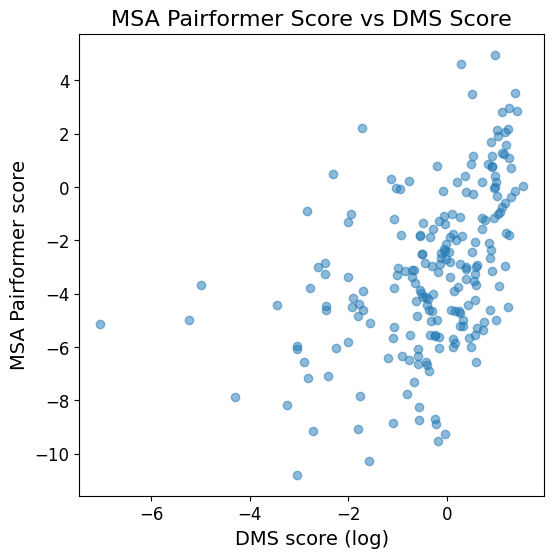

In [ ]:
rho, pval = spearmanr(dms_df["MSA_Pairformer_Score"], dms_df["DMS_score"])
print(f"Spearman's rho: {rho}, p-value: {pval}")
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.log(dms_df["DMS_score"]), dms_df["MSA_Pairformer_Score"], alpha=0.5)
ax.set_xlabel("DMS score (log)", fontsize=14)
ax.set_ylabel("MSA Pairformer score", fontsize=14)
ax.set_title("MSA Pairformer Score vs DMS Score", size=16)
ax.tick_params(labelsize=12)

# csv reference presentation


In [9]:
df = pd.read_csv("/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/data/reference_files/viral_dms_reference.csv")

boolean_proteingym = df.columns[9]

first_col = df.columns[0]
yes_names = df.loc[df[boolean_proteingym] == "Yes", first_col]
no_names = df.loc[df[boolean_proteingym] == "No", first_col]
print(len(yes_names))
print(no_names)


23
0                   LASSA_GP_Carr
2        SARS2_PLPRO_Wu_abundance
3         SARS2_PLPRO_Wu_activity
4         SARS2_PRD0038_RBD_Starr
6                RmYN02_RBD_Starr
7                RsYN04_RBD_Starr
8          SARS2_XBB15_RBD_Taylor
9       SARS2_BA1_SPIKE_Dadonaite
10    SARS2_DELTA_SPIKE_Dadonaite
18            IAV_H5_HA_Dadonaite
24                 NIPAH_F_Larsen
26                CVB3_2A_Alvarez
27                CVB3_2B_Alvarez
28                CVB3_2C_Alvarez
29                CVB3_3A_Alvarez
30                CVB3_3B_Alvarez
31                CVB3_3C_Alvarez
32                CVB3_3D_Alvarez
33               CVB3_VP1_Alvarez
34               CVB3_VP3_Alvarez
35              EV_CAPSD_Bakhache
36                EV_REP_Bakhache
Name: DMS ID, dtype: object


SARS2_PLPRO_Wu_activity: Spearman's rho=0.2977, p-value=1.3345e-109
RmYN02_RBD_Starr: Spearman's rho=0.2467, p-value=4.0871e-49


/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


LASSA_GP_Carr: Spearman's rho=0.3560, p-value=2.6297e-275
SARS2_PLPRO_Wu_abundance: Spearman's rho=0.3058, p-value=6.9855e-116


/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


RsYN04_RBD_Starr: Spearman's rho=0.3614, p-value=6.7469e-116


/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


SARS2_PRD0038_RBD_Starr: Spearman's rho=0.2401, p-value=1.5270e-53

=== Summary across all viruses ===
rho mean = 0.3013, std = 0.0472
pval mean = 6.8120e-50, std = 1.5232e-49


/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mooolab/anaconda3/envs/yoosun/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


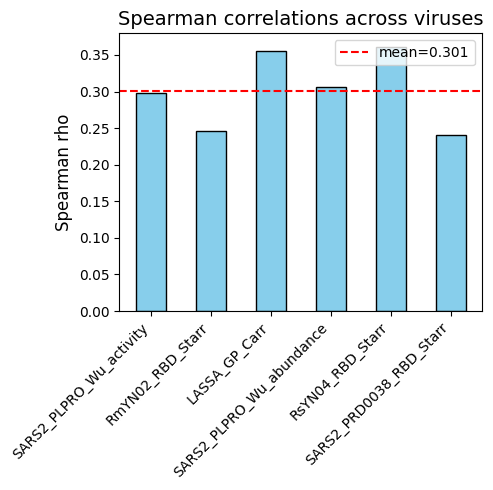

In [23]:
result_path = '/mnt/mooo/yoosun/army/MSA_Pairformer/priority_viruses/results/mine/no_proteingym/'

# 결과 저장용 리스트
rho_list, pval_list = [], []

# 모든 바이러스 폴더 순회
for virus_name in os.listdir(result_path):
    virus_dir = os.path.join(result_path, virus_name)
    if not os.path.isdir(virus_dir):
        continue

    # 폴더 내 CSV 찾기
    csv_files = [f for f in os.listdir(virus_dir) if f.endswith(".csv")]
    if len(csv_files) == 0:
        print(f"[Skip] No CSV in {virus_name}")
        continue

    # 첫 번째 CSV만 사용 (필요시 반복문으로 바꿔도 됨)
    csv_path = os.path.join(virus_dir, csv_files[0])
    dms_df = pd.read_csv(csv_path)

    # Spearman 상관 계산
    rho, pval = spearmanr(dms_df["MSA_Pairformer_Score"], dms_df["DMS_score"])
    rho_list.append(rho)
    pval_list.append(pval)

    print(f"{virus_name}: Spearman's rho={rho:.4f}, p-value={pval:.4e}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(np.log(dms_df["DMS_score"]), dms_df["MSA_Pairformer_Score"], alpha=0.5)
    plt.xlabel("DMS score (log)", fontsize=14)
    plt.ylabel("MSA Pairformer score", fontsize=14)
    plt.title(f"{virus_name}\nSpearman rho={rho:.3f}", size=16)
    plt.tick_params(labelsize=12)

    # 바이러스별 plot 저장 (optional)
    save_plot_path = os.path.join(virus_dir, f"{virus_name}_scatter.png")
    plt.tight_layout()
    plt.savefig(save_plot_path, dpi=200)
    plt.close()

# 전체 평균, 표준편차 계산
rho_mean = np.mean(rho_list)
rho_std = np.std(rho_list)
pval_mean = np.mean(pval_list)
pval_std = np.std(pval_list)

print("\n=== Summary across all viruses ===")
print(f"rho mean = {rho_mean:.4f}, std = {rho_std:.4f}")
print(f"pval mean = {pval_mean:.4e}, std = {pval_std:.4e}")

# Summary bar plot (with virus names)
virus_names = [name for name in os.listdir(result_path) if os.path.isdir(os.path.join(result_path, name))]

plt.figure(figsize=(max(5, len(virus_names)*0.6), 5))
plt.bar(virus_names, rho_list, color='skyblue', edgecolor='k', width=0.5)
plt.axhline(rho_mean, color="red", linestyle="--", label=f"mean={rho_mean:.3f}")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Spearman rho", fontsize=12)
plt.title("Spearman correlations across viruses", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()